C:\Users\barbc\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\barbc\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\barbc\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 2.2960 | Accuracy: 0.2130 | F1-score: 0.2072
Epoch 1/50 - Val Loss: 2.4596 | Accuracy: 0.2233 | F1-score: 0.1811

Epoch 2/50 - Train Loss: 1.9630 | Accuracy: 0.3287 | F1-score: 0.3107
Epoch 2/50 - Val Loss: 1.9263 | Accuracy: 0.2897 | F1-score: 0.2716

Epoch 3/50 - Train Loss: 1.7712 | Accuracy: 0.3940 | F1-score: 0.3732
Epoch 3/50 - Val Loss: 1.6910 | Accuracy: 0.4064 | F1-score: 0.3802

Epoch 4/50 - Train Loss: 1.6583 | Accuracy: 0.4415 | F1-score: 0.4215
Epoch 4/50 - Val Loss: 1.5631 | Accuracy: 0.4791 | F1-score: 0.4561

Epoch 5/50 - Train Loss: 1.5320 | Accuracy: 0.4771 | F1-score: 0.4606
Epoch 5/50 - Val Loss: 1.4765 | Accuracy: 0.4660 | F1-score: 0.4433

Epoch 6/50 - Train Loss: 1.5136 | Accuracy: 0.4883 | F1-score: 0.4732
Epoch 6/50 - Val Loss: 1.5953 | Accuracy: 0.5021 | F1-score: 0.4740

Epoch 7/50 - Train Loss: 1.4432 | Accuracy: 0.5114 | F1-score: 0.4975
Epoch 7/50 - Val Loss: 1.3757 | Accuracy: 0.5084 | F1-score: 0.4952

Epoch 8/50 - Train Loss: 1.

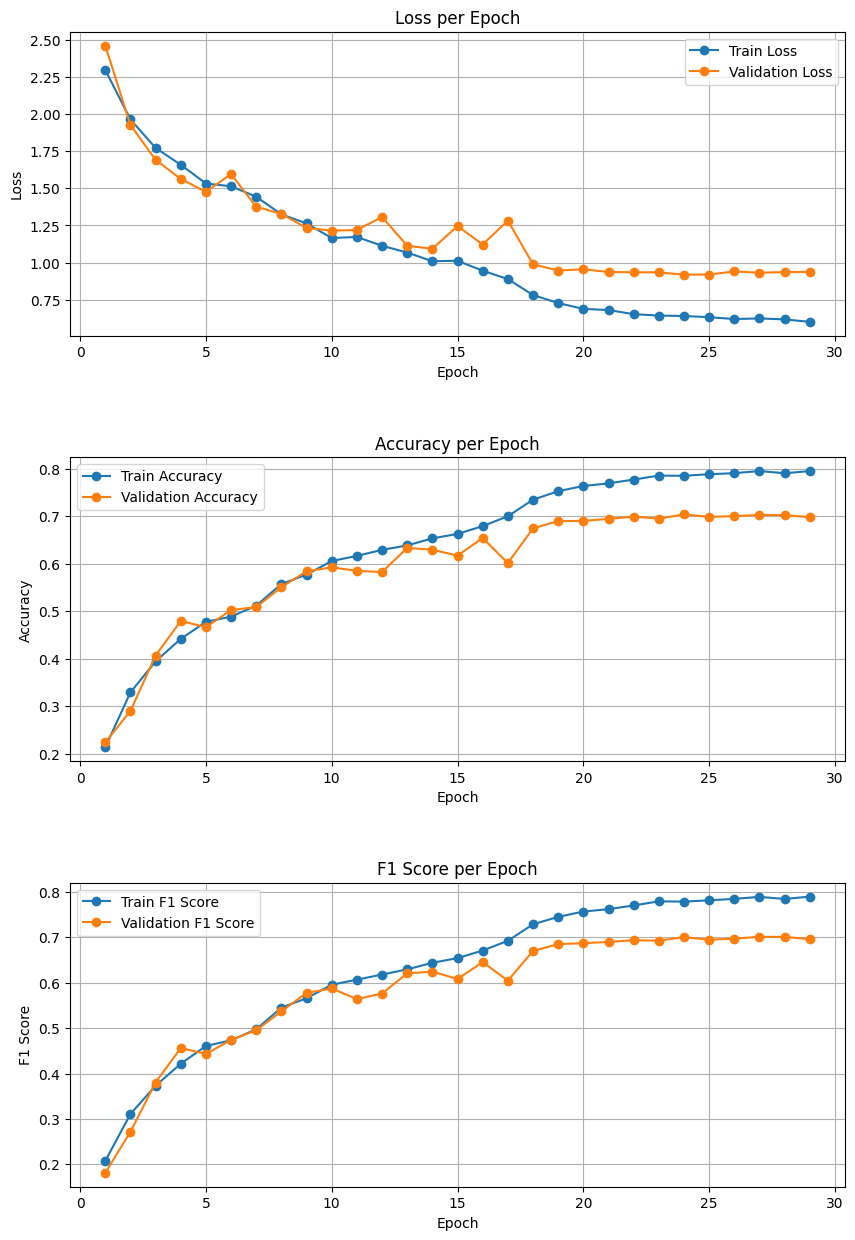

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# ------------------------------
# Setup Device
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Data Transformations (Simpler Augmentation)
# ------------------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------------
# Data Loading
# ------------------------------
train_dir = os.path.join('state_dataset', 'train')
val_dir = os.path.join('state_dataset', 'valid')

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ------------------------------
# Model Setup (Dropout and Modified Classifier)
# ------------------------------
# Load a pretrained ResNet18 and modify its classifier by adding a dropout layer.
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.6),  # Dropout helps prevent overfitting.
    nn.Linear(num_features, 11)
)
model = model.to(device)

# ------------------------------
# Loss Function, Optimizer, and Learning Rate Scheduler
# ------------------------------
criterion = nn.CrossEntropyLoss()  # Standard cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.002)  # Basic Adam optimizer
# Scheduler reduces the learning rate when the validation loss plateaus.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                 factor=0.009, patience=2, verbose=True)

# ------------------------------
# Early Stopping Parameters
# ------------------------------
patience = 5  # Stop training if validation loss doesn't improve for 3 consecutive epochs.
best_val_loss = float('inf')
epochs_without_improvement = 0

# ------------------------------
# Metric History Lists for Plotting
# ------------------------------
epochs_history = []
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []
train_f1_history = []
val_f1_history = []

# ------------------------------
# Training Loop
# ------------------------------
num_epochs = 50
for epoch in range(num_epochs):
    # ----- Training Phase -----
    model.train()  # Enable training mode (dropout active)
    running_loss = 0.0
    all_train_preds = []
    all_train_labels = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()               # Reset gradients
        outputs = model(inputs)               # Forward pass
        loss = criterion(outputs, labels)     # Compute loss
        loss.backward()                       # Backpropagation
        optimizer.step()                      # Update weights
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())
    
    train_loss = running_loss / len(train_dataset)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    
    # ----- Validation Phase -----
    model.eval()  # Set model to evaluation mode (dropout disabled)
    val_running_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
    
    val_loss = val_running_loss / len(val_dataset)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    
    # Record metrics for this epoch
    epochs_history.append(epoch + 1)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)
    train_f1_history.append(train_f1)
    val_f1_history.append(val_f1)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.4f} | F1-score: {train_f1:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Val Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.4f} | F1-score: {val_f1:.4f}\n")
    
    # ----- Learning Rate Scheduler Step -----
    scheduler.step(val_loss)
    
    # ----- Early Stopping Check -----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Optionally, save the best model weights.
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# ------------------------------
# Plotting Metrics with Matplotlib
# ------------------------------
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.subplots_adjust(hspace=0.4)

# Loss Plot
axes[0].plot(epochs_history, train_loss_history, marker='o', label="Train Loss")
axes[0].plot(epochs_history, val_loss_history, marker='o', label="Validation Loss")
axes[0].set_title("Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Accuracy Plot
axes[1].plot(epochs_history, train_accuracy_history, marker='o', label="Train Accuracy")
axes[1].plot(epochs_history, val_accuracy_history, marker='o', label="Validation Accuracy")
axes[1].set_title("Accuracy per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)

# F1 Score Plot
axes[2].plot(epochs_history, train_f1_history, marker='o', label="Train F1 Score")
axes[2].plot(epochs_history, val_f1_history, marker='o', label="Validation F1 Score")
axes[2].set_title("F1 Score per Epoch")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("F1 Score")
axes[2].legend()
axes[2].grid(True)

plt.show()